In [2]:
import datetime
import os
from glob import glob

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # to edit text in Illustrator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import tqdm
import warnings

from obspy import UTCDateTime, read, read_inventory
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD
from ww32seismo import *

%load_ext autoreload
%autoreload 2
#import seismosocialdistancing

# Setting things up
This assumes that you already downloaded the mseed data and the station .xml fil

In [3]:
station = "UCC"
net = "BE"
comp = "HHZ"
start = UTCDateTime("2021-10-01")
end = UTCDateTime("2021-10-31")
datelist = pd.date_range(start.datetime, min(end, UTCDateTime()).datetime, freq="D")
resp = read_inventory(os.path.join("DATA", "MSEED", "*{}*.xml".format(station)))

# Loading the data and saving the psds in .npz format

This should only process 2 missing days of data

In [3]:
pbar = tqdm.tqdm(datelist)
force_reprocess = False

for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    pbar.set_description("Processing %s" %datestr)
    fn = "{}.{}*.{}__{}*".format(net, station, comp,day.strftime("%Y%m%dT"))
    fn_in = glob(os.path.join("DATA", "MSEED", fn))
    if fn_in:
        fn_in = fn_in[0]
    else:
        continue
    
    stall = read(fn_in, headonly=True)
    for mseedid in list(set([tr.id for tr in stall])):
        fn_out = "{}_{}_{}.npz".format(station, datestr, mseedid)
        fn_out = os.path.join("DATA", "NPZ", fn_out)
        if os.path.isfile(fn_out) and not force_reprocess:
            continue
        st = read(fn_in, sourcename=mseedid)
        st.attach_response(resp)
        ppsd = PPSD(st[0].stats, metadata=resp,
                    ppsd_length=1800, overlap=0.0,
                    period_smoothing_width_octaves=0.025,
                    period_step_octaves=0.0125,
                    period_limits=(0.008, 50),
                    db_bins=(-200, 20, 0.25))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ppsd.add(st)
        ppsd.save_npz(fn_out)
        del st, ppsd
    del stall

Processing 2021-10-31: 100%|██████████| 31/31 [00:01<00:00, 18.49it/s]


In [4]:
ppsds = {}
pbar = tqdm.tqdm(datelist)
for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    
    fn_pattern = "{}_{}_*.npz".format(station, datestr)
    fn_pattern = glob(os.path.join("DATA", "NPZ", fn_pattern))
    pbar.set_description("Reading %s" % fn_pattern)
    
    if fn_pattern:
        fn = fn_pattern[0]
    else:
        continue    
    mseedid = fn.replace(".npz", "").split("_")[-1]
    if mseedid not in ppsds:
        ppsds[mseedid] = PPSD.load_npz(fn, allow_pickle=True)
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ppsds[mseedid].add_npz(fn, allow_pickle=True)

Reading ['DATA/NPZ/UCC_2021-10-31_BE.UCC..HHZ.npz']: 100%|██████████| 31/31 [00:00<00:00, 70.56it/s]


# Plotting the spectrogram

This might take a while, skip it if you feel like your laptop is a patato

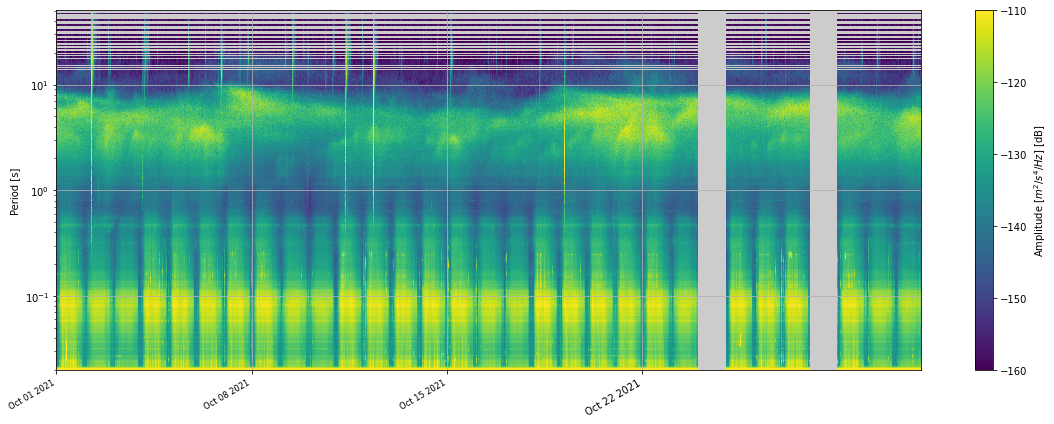

[None]

In [5]:
plt.rcParams['figure.figsize'] = (16,6)
plt.rcParams['axes.facecolor'] = "w"
[ppsd.plot_spectrogram(clim=(-160,-110)) for mseedid, ppsd in ppsds.items()]

# Saving the displacement RMS for the frequency range of interest into a .pkl file

In [5]:
# This is the frequency range of interest in the model's results
freqs = [(0.08,0.6)]

displacement_RMS = {}
for mseedid, ppsd in tqdm.tqdm(ppsds.items()):
    ind_times = pd.DatetimeIndex([d.datetime for d in ppsd.current_times_used])
    data = pd.DataFrame(ppsd.psd_values, index=ind_times, columns=1./ppsd.period_bin_centers)
    data = data.sort_index(axis=1)
    displacement_RMS[mseedid] = df_rms(data, freqs, output="DISP")
    displacement_RMS[mseedid].to_pickle("DATA/%s.pkl" % mseedid)

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
